# Modeling FQHC Total Health Center Funding Predictions

The goal of this notebook it to explore various regression models and their accuracy to predict the total health center funding a new entity could receive. 

During preprocessing, I saved 4 train/test splits based on:
1. whether RobustScaler() or PowerTransformer() was applied
2. whether missing data was imputed or removed

I will train and test Linear Regression models and Random Forest Regression models on the 4 data splits. I will also use PCA to reduce the number of components and add relevant components to the existing data (if this increases predictive capabilities)

All results will be scored with R2, Mean Squared Error, and Mean Absolute Error. I'll save cross-validation scoring results for the Linear Models. 

I plan to use GridSearch for the Random Forest Regressors to identify the best parameters. 

Cross-validation for all models will involve 5-fold splits. 

# Import Packages

In [10]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import plotly.express as px
from configuration.config import DATA_PATH, MODEL_DATA_PATH

In [12]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

## Tracking Scoring Metrics for Models

In [13]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
   
    global y_pred

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Metrics
    rmse_train = root_mean_squared_error(y_train, y_pred_train)
    rmse_test = root_mean_squared_error(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    print(f'R2 Score: {r2_test}, Root Mean Squared Error: {rmse_test}, Mean Absolute Error: {mae_test}')
    
    y_pred = y_pred_test
   
    return rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test



In [14]:
model_scores = pd.DataFrame({
                             'model_type':[],
                             'train_test_split':[],
                             'is_pca':[], 
                             'score_rmse_train':[],
                             'score_rmse_test':[],
                             'score_mae_train':[],
                             'score_mae_test':[],
                             'score_r2_train':[],
                             'score_r2_test':[],
                             'cv_mean_r2':[],
                             'cv_std_r2':[],
                             'cv_mean_rmse':[],
                             'cv_std_rmse':[],
                             'cv_mean_mae':[],
                             'cv_std_mae':[],
                             'best_params':[] 
                            })
model_scores['is_pca'] = model_scores['is_pca'].astype(bool)
model_scores

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params


In [15]:
def add_model_score(model_type, train_test_split, is_pca, score_rmse_train, score_rmse_test, score_mae_train, score_mae_test, score_r2_train, score_r2_test, cv_mean_r2, cv_std_r2, cv_mean_rmse, cv_std_rmse, cv_mean_mae, cv_std_mae, best_params=None):
    """
    Adds a row to the model_scores DataFrame with the specified model performance metrics.

    Parameters:
        model_scores (pd.DataFrame): DataFrame to log the results.
        model_type (str): Type of the model.
        train_test_split (str): Description of the data split used.
        is_pca (bool): Indicates if PCA was applied.
        score_rmse (float): Root Mean Squared Error of the model.
        score_mae (float): Mean Absolute Error of the model.
        score_r2 (float): R2 Score of the model.
        cross_val_mean (float): Mean of cross-validation scores.
        cross_val_std (float): Standard deviation of cross-validation scores.
        best_params (dict): Best parameters from model tuning.

    Returns:
        pd.DataFrame: Updated DataFrame with the new model scores.
    """
    global model_scores

    new_row_df = pd.DataFrame([{
        'model_type': model_type,
        'train_test_split': train_test_split,
        'is_pca': bool(is_pca),
        'score_rmse_train': score_rmse_train,
        'score_rmse_test': score_rmse_test,
        'score_mae_train': score_mae_train,
        'score_mae_test': score_mae_test,
        'score_r2_train': score_r2_train,
        'score_r2_test': score_r2_test,
        'cv_mean_r2': cv_mean_r2,
        'cv_std_r2': cv_std_r2,
        'cv_mean_rmse': cv_mean_rmse,
        'cv_std_rmse': cv_std_rmse,
        'cv_mean_mae': cv_mean_mae,
        'cv_std_mae': cv_std_mae,
        'best_params': best_params
    }])

    model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)

In [16]:
# import train/test splits for modeling the reduced and robust scaled data
X_train_rr = pd.read_csv(MODEL_DATA_PATH + 'X_train_reduced_robust.csv')
X_test_rr = pd.read_csv(MODEL_DATA_PATH + 'X_test_reduced_robust.csv')

# import train/test splits for modeling the reduced and power transformed data
X_train_rp = pd.read_csv(MODEL_DATA_PATH + 'X_train_reduced_power.csv')
X_test_rp = pd.read_csv(MODEL_DATA_PATH + 'X_test_reduced_power.csv')

# import train/test splits for modeling the imputed and robust scaled data
X_train_ir = pd.read_csv(MODEL_DATA_PATH + 'X_train_imputed_robust.csv')
X_test_ir = pd.read_csv(MODEL_DATA_PATH + 'X_test_imputed_robust.csv')

# import train/test splits for modeling the imputed and power transformed data
X_train_ip = pd.read_csv(MODEL_DATA_PATH + 'X_train_imputed_power.csv')
X_test_ip = pd.read_csv(MODEL_DATA_PATH + 'X_test_imputed_power.csv')

y_train = pd.read_csv(MODEL_DATA_PATH + 'y_train_data.csv').values.ravel()
y_test = pd.read_csv(MODEL_DATA_PATH + 'y_test_data.csv').values.ravel()

y_train_rounded = pd.read_csv(MODEL_DATA_PATH + 'y_train_rounded.csv').values.ravel()
y_test_rounded = pd.read_csv(MODEL_DATA_PATH + 'y_test_rounded.csv').values.ravel()

# Linear Models

## I. Reduced & Robust Scaled Data


In [17]:
print(X_train_rr.shape, y_train.shape, y_train_rounded.shape)
print(X_test_rr.shape, y_test.shape, y_test_rounded.shape)

(939, 54) (939,) (939,)
(403, 54) (403,) (403,)


### A. Linear Regression

In [18]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rr, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.5987099881669747, 0.049293575938529594),
 'neg_mean_squared_error': (-3031148605996.044, 167555256950.67242),
 'neg_mean_absolute_error': (-1150322.350841745, 37108.60169878864)}

#### Model Training and Evaluation

R2 Score: -0.29324276253507, Root Mean Squared Error: 3040477.797774148, Mean Absolute Error: 1240233.9928990544


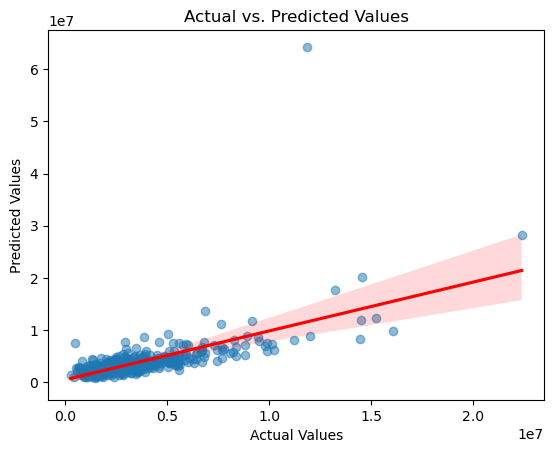

In [19]:
linear_model.fit(X_train_rr, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rr, X_test_rr, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_robust', bool(False), 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

In [20]:
model_scores

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
0,Linear Regression,reduced_robust,False,1.508451e+06,3.040478e+06,1.034526e+06,1.240234e+06,0.703222,-0.293243,0.59871,0.049294,-3.031149e+12,1.675553e+11,-1.150322e+06,37108.601699,None


### B. Linear Regression with PCA

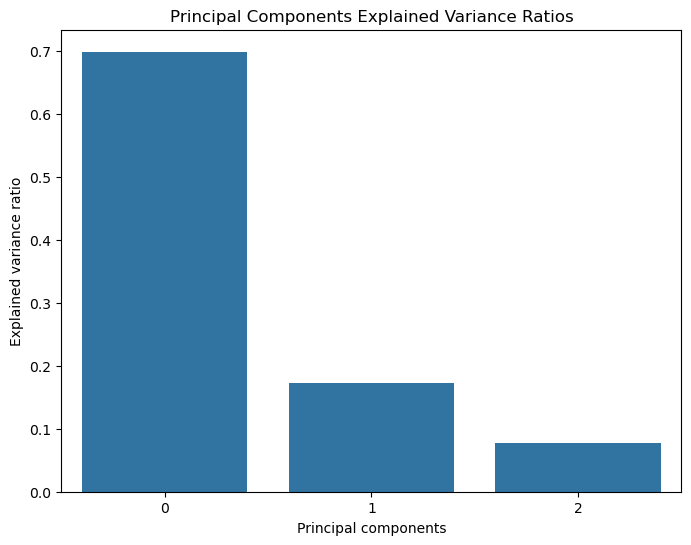

                             PC 1      PC 2      PC 3
public_insurance         0.955847  0.002913 -0.289544
public_insurance_ratio   0.292071 -0.053051  0.952575
public_housing_patients  0.012504  0.031431 -0.029566
total_other_revenue      0.011502  0.006497 -0.031096
lep_patients             0.011393  0.030770 -0.020317
migrant_patients         0.011018  0.982568  0.055799
hispanic_any_race        0.009456  0.044173 -0.018429
medicaid                 0.007005  0.028729 -0.016049
total_patients           0.006957  0.022060 -0.015698
uninsured                0.006923  0.015501 -0.013596
diverse_patients_sum     0.006893  0.003537 -0.012106
total_grant_funding      0.005799  0.013278 -0.012184
low_income               0.005742  0.030094 -0.011599
homeless_patients        0.005214  0.021706 -0.017198
private_insurance        0.004356  0.011897 -0.014238


In [21]:
# create PCA object
pca = PCA(n_components=3)

pca.fit(X_train_rr)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_rr)
X_test_pca = pca.transform(X_test_rr)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3'], 
                        index=X_train_rr.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))


In [22]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3'], 
                              index=X_train_rr.index)
X_train_pca_rr = pd.concat([X_train_rr, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3'], 
                              index=X_test_rr.index)
X_test_pca_rr = pd.concat([X_test_rr, X_test_pca_df], axis=1)

R2 Score: -0.3040336024674899, Root Mean Squared Error: 3053136.346453128, Mean Absolute Error: 1240941.4218362283


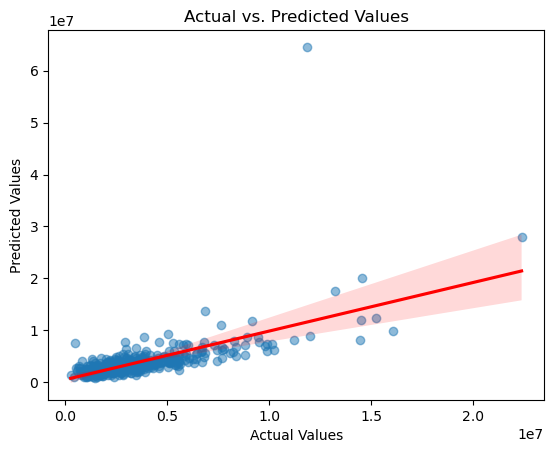

In [23]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_rr, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_rr, X_test_pca_rr, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_robust', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

In [24]:
model_scores

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
0,Linear Regression,reduced_robust,False,1.508451e+06,3.040478e+06,1.034526e+06,1.240234e+06,0.703222,-0.293243,0.59871,0.049294,-3.031149e+12,1.675553e+11,-1.150322e+06,37108.601699,None
1,Linear Regression,reduced_robust,True,1.508467e+06,3.053136e+06,1.034449e+06,1.240941e+06,0.703216,-0.304034,0.59871,0.049294,-3.031149e+12,1.675553e+11,-1.150322e+06,37108.601699,None


### Rounded

R2 Score: -0.2905530643855605, Root Mean Squared Error: 3036991.7533092485, Mean Absolute Error: 1240813.5266288759


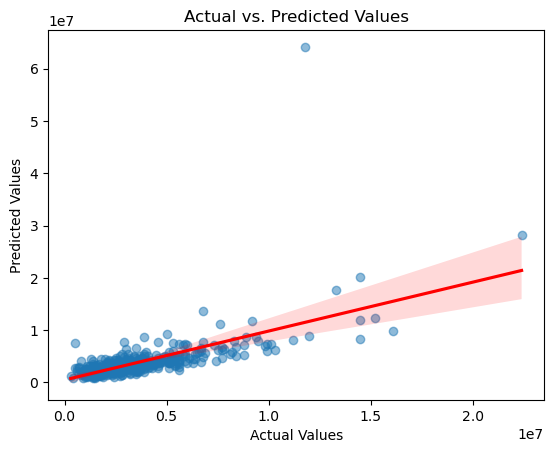

In [25]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rr, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores

linear_model.fit(X_train_rr, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rr, X_test_rr, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

## II. Reduced & Power Transformed Data

### A. Linear Regression

In [26]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rp, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.5978091977488381, 0.01881284399679693),
 'neg_mean_squared_error': (-3061323848483.8022, 202302986007.34518),
 'neg_mean_absolute_error': (-1224908.2178983926, 68628.52430286654)}

R2 Score: 0.6479558389841737, Root Mean Squared Error: 1586354.9968192321, Mean Absolute Error: 1181633.1993025062


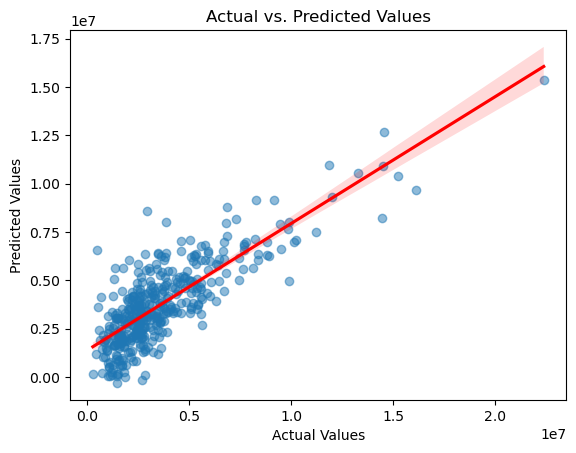

In [27]:
linear_model.fit(X_train_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rp, X_test_rp, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### B. Linear Regression with PCA

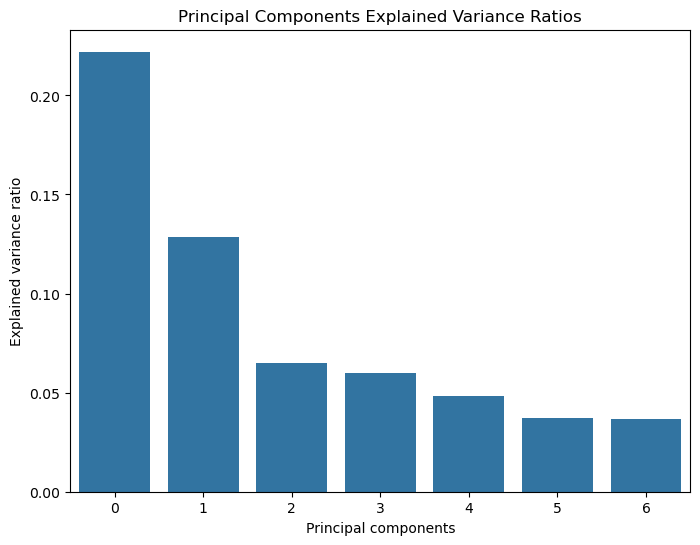

                                 PC 1      PC 2      PC 3      PC 4      PC 5  \
total_patients               0.265807  0.110612 -0.003701 -0.027406 -0.024441   
medicaid                     0.259587  0.071188  0.017123 -0.112353 -0.016898   
low_income                   0.256571 -0.011945  0.039763  0.013966 -0.147706   
hispanic_any_race            0.250709 -0.066217 -0.111683  0.106777  0.098822   
lep_patients                 0.240606 -0.099566 -0.127028  0.070026  0.113762   
uninsured                    0.237310 -0.035639 -0.045730  0.116993 -0.017148   
total_grant_funding          0.234946  0.018797  0.021012 -0.005527  0.057810   
TotalWeeklyHoursOfOperation  0.220936  0.121124  0.082161  0.024772 -0.150747   
total_sites                  0.209348  0.115541  0.100610  0.029707 -0.173776   
ZipCode_Count                0.208358  0.050666  0.046079 -0.061718  0.004802   
diverse_patients_sum         0.195785 -0.040356  0.111568 -0.219794 -0.058361   
medicare_18_up              

In [28]:
# create PCA object
pca = PCA(n_components=7)

pca.fit(X_train_rp)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_rp)
X_test_pca = pca.transform(X_test_rp)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                        index=X_train_rp.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))


In [29]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_train_rp.index)
X_train_pca_rp = pd.concat([X_train_rp, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_test_rp.index)

X_test_pca_rp = pd.concat([X_test_rp, X_test_pca_df], axis=1)

R2 Score: 0.6455813871498314, Root Mean Squared Error: 1591695.7947511047, Mean Absolute Error: 1181426.5716042162


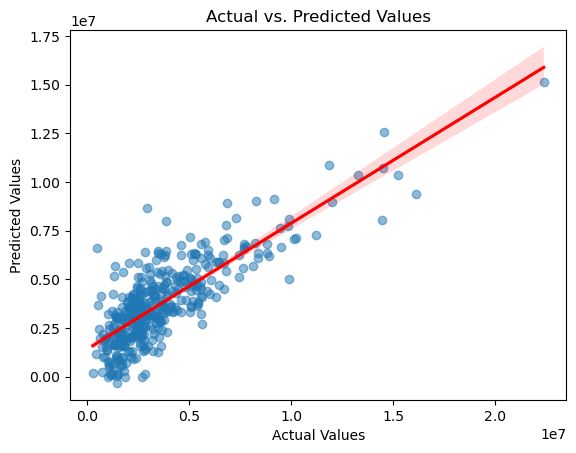

In [30]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_rp, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_rp, X_test_pca_rp, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_power', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Rounded

In [31]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rp, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores



{'r2': (0.5975882070881171, 0.01890230416912608),
 'neg_mean_squared_error': (-3063557657999.8525, 201073011108.3946),
 'neg_mean_absolute_error': (-1226610.134146704, 68735.18835199255)}

R2 Score: 0.6482774845721363, Root Mean Squared Error: 1585461.7344441246, Mean Absolute Error: 1181161.266882975


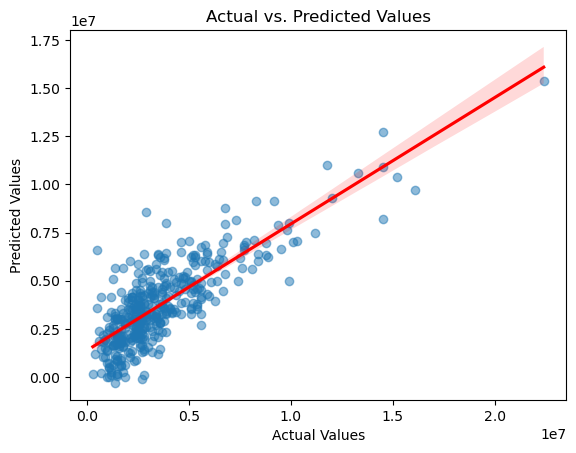

In [32]:
linear_model.fit(X_train_rp, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rp, X_test_rp, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_power_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

## III. Imputed & Robust Scaled Data

### A. Linear Regression

In [33]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ir, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.5841375845244934, 0.04929115090975368),
 'neg_mean_squared_error': (-3146023652618.357, 213180053317.71664),
 'neg_mean_absolute_error': (-1166114.1258730213, 37196.09727342724)}

R2 Score: -0.24113265528003303, Root Mean Squared Error: 2978591.2498694533, Mean Absolute Error: 1242208.5400343945


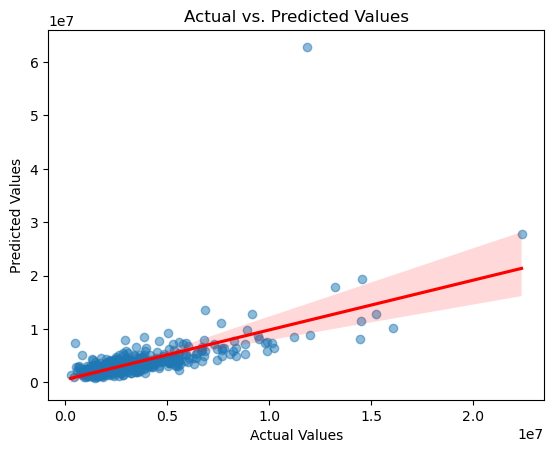

In [34]:
linear_model.fit(X_train_ir, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ir, X_test_ir, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Linear Regression PCA

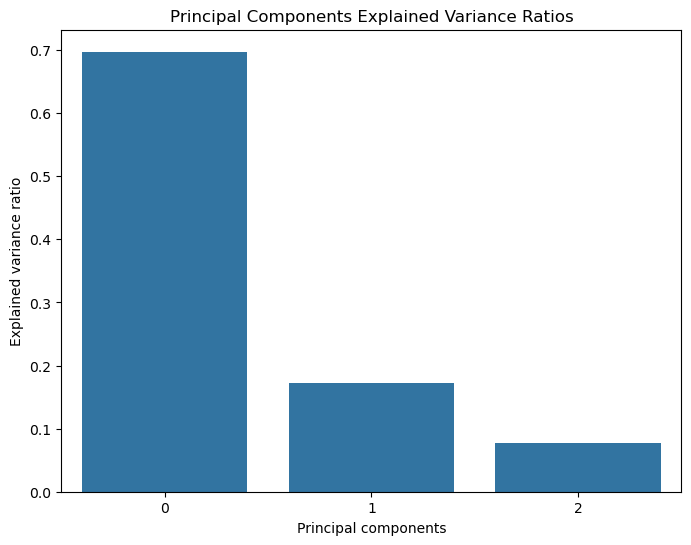

                             PC 1      PC 2      PC 3
public_insurance         0.955738  0.002405 -0.288683
public_insurance_ratio   0.291960 -0.054228  0.951954
public_housing_patients  0.012534  0.031671 -0.029995
total_other_revenue      0.011527  0.006756 -0.031593
lep_patients             0.011414  0.030907 -0.020538
migrant_patients         0.011207  0.981703  0.058219
hispanic_any_race        0.009480  0.044305 -0.018634
total_cost_care          0.008179  0.022114 -0.019557
total_visits             0.007682  0.025102 -0.017194
total_sfs                0.007582  0.015270 -0.015347
medicaid                 0.007024  0.028843 -0.016228
total_patients           0.006974  0.022175 -0.015885
uninsured                0.006939  0.015616 -0.013804
diverse_patients_sum     0.006902  0.003621 -0.012257
enabling_patients        0.006833  0.011118 -0.013656


In [35]:
# create PCA object
pca = PCA(n_components=3)

pca.fit(X_train_ir)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_ir)
X_test_pca = pca.transform(X_test_ir)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3'], 
                        index=X_train_ir.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))

In [36]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3'], 
                              index=X_train_ir.index)
X_train_pca_ir = pd.concat([X_train_ir, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3'], 
                              index=X_test_ir.index)
X_test_pca_ir = pd.concat([X_test_ir, X_test_pca_df], axis=1)


R2 Score: -0.2417698240777817, Root Mean Squared Error: 2979355.7216928503, Mean Absolute Error: 1242100.081885856


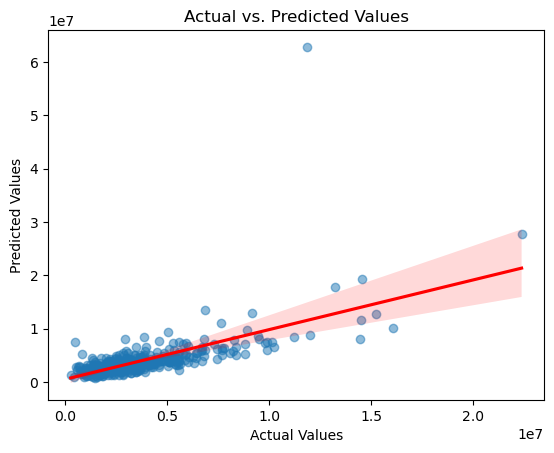

In [37]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_ir, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_ir, X_test_pca_ir, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_robust', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Rounded

R2 Score: -0.24083960942700067, Root Mean Squared Error: 2977923.2714309706, Mean Absolute Error: 1242558.506814012


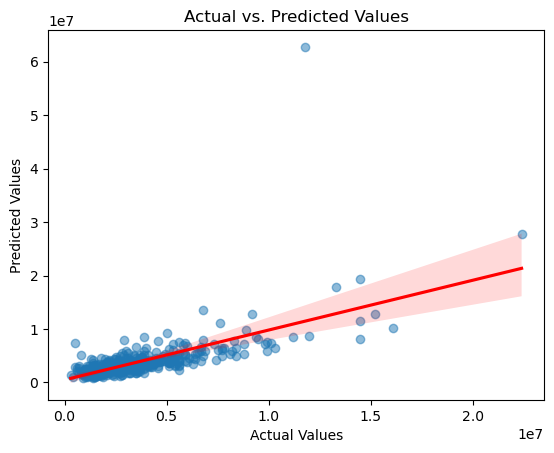

In [38]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ir, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores

linear_model.fit(X_train_ir, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ir, X_test_ir, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

## IV. Imputed & Power Transformed Data

### A. Linear Regression

In [39]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ip, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.5953357866220951, 0.018926158746890777),
 'neg_mean_squared_error': (-3083386174679.3955, 246247451684.60745),
 'neg_mean_absolute_error': (-1236019.8346411653, 62415.884105066594)}

R2 Score: 0.64756137354869, Root Mean Squared Error: 1587243.5032772939, Mean Absolute Error: 1181993.497055347


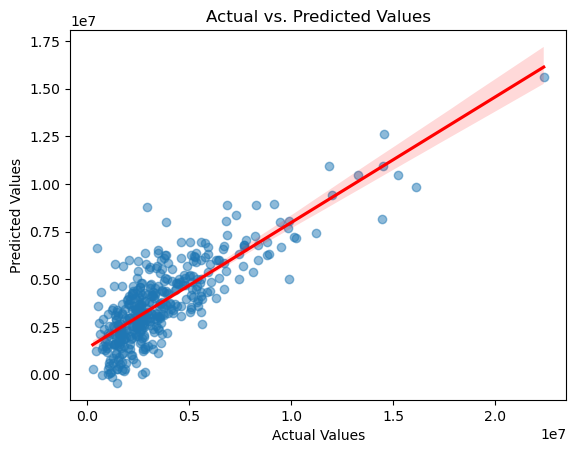

In [40]:
linear_model.fit(X_train_ip, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ip, X_test_ip, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Linear Regression PCA

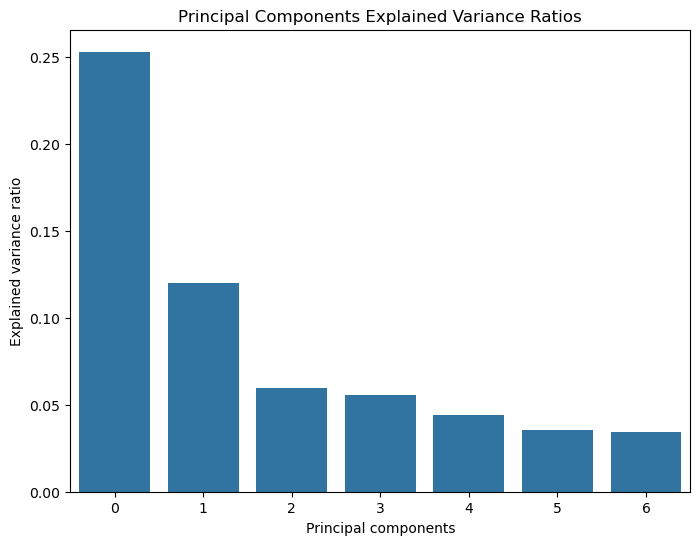

                                 PC 1      PC 2      PC 3      PC 4      PC 5  \
total_visits                 0.243157  0.085915  0.019367 -0.023991 -0.008927   
total_patients               0.241771  0.097790 -0.007241 -0.035188 -0.025932   
total_cost_care              0.237923  0.085012  0.049060 -0.022422  0.041763   
medicaid                     0.233098  0.060714  0.022056 -0.124414 -0.017755   
low_income                   0.229900 -0.023681  0.034422  0.006200 -0.148005   
hispanic_any_race            0.222954 -0.078740 -0.119809  0.085936  0.100315   
total_grant_funding          0.214417  0.007789  0.020920 -0.008382  0.057328   
uninsured                    0.214082 -0.049586 -0.060928  0.112866 -0.018617   
lep_patients                 0.211650 -0.110635 -0.132542  0.046945  0.114782   
TotalWeeklyHoursOfOperation  0.199154  0.108540  0.074864  0.023437 -0.155574   
total_sfs                    0.197152 -0.042284 -0.074529  0.094248  0.007118   
ZipCode_Count               

In [41]:
# create PCA object
pca = PCA(n_components=7)

pca.fit(X_train_ip)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_ip)
X_test_pca = pca.transform(X_test_ip)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                        index=X_train_ip.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))

In [42]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_train_ip.index)
X_train_pca_ip = pd.concat([X_train_ip, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_test_ip.index)

X_test_pca_ip = pd.concat([X_test_ip, X_test_pca_df], axis=1)



R2 Score: 0.6390299797207084, Root Mean Squared Error: 1606339.6340551132, Mean Absolute Error: 1184694.2933451307


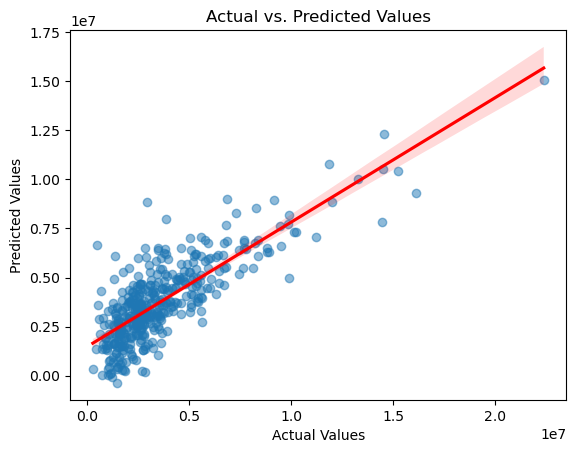

In [43]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_ip, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_ip, X_test_pca_ip, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [44]:
add_model_score('Linear Regression', 'imputed_power', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Rounded

R2 Score: 0.6478469720575089, Root Mean Squared Error: 1586431.749655295, Mean Absolute Error: 1180932.8651215837


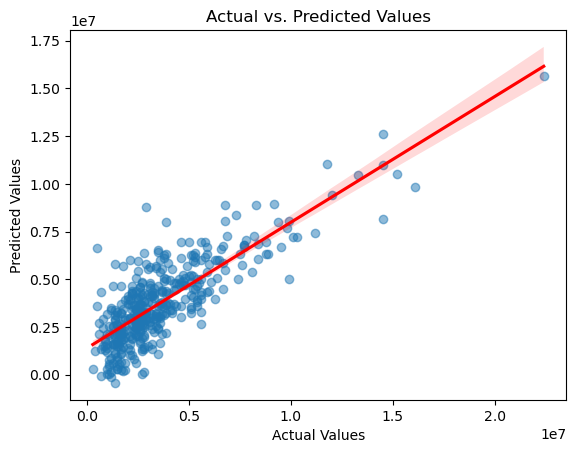

In [45]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ip, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores

linear_model.fit(X_train_ip, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ip, X_test_ip, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_power_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

# Scores Analysis

In [46]:
model_scores.sort_values('cv_mean_r2',ascending=False)

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
2,Linear Regression,reduced_robust_rounded,False,1.508287e+06,3.036992e+06,1.034581e+06,1.240814e+06,0.703325,-0.290553,0.598756,0.048830,-3.031920e+12,1.690306e+11,-1.150427e+06,37008.189965,None
0,Linear Regression,reduced_robust,False,1.508451e+06,3.040478e+06,1.034526e+06,1.240234e+06,0.703222,-0.293243,0.598710,0.049294,-3.031149e+12,1.675553e+11,-1.150322e+06,37108.601699,None
1,Linear Regression,reduced_robust,True,1.508467e+06,3.053136e+06,1.034449e+06,1.240941e+06,0.703216,-0.304034,0.598710,0.049294,-3.031149e+12,1.675553e+11,-1.150322e+06,37108.601699,None
3,Linear Regression,reduced_power,False,1.613415e+06,1.586355e+06,1.130684e+06,1.181633e+06,0.660483,0.647956,0.597809,0.018813,-3.061324e+12,2.023030e+11,-1.224908e+06,68628.524303,None
4,Linear Regression,reduced_power,True,1.617562e+06,1.591696e+06,1.130458e+06,1.181427e+06,0.658735,0.645581,0.597809,0.018813,-3.061324e+12,2.023030e+11,-1.224908e+06,68628.524303,None
5,Linear Regression,reduced_power_rounded,False,1.614146e+06,1.585462e+06,1.132288e+06,1.181161e+06,0.660220,0.648277,0.597588,0.018902,-3.063558e+12,2.010730e+11,-1.226610e+06,68735.188352,None
9,Linear Regression,imputed_power,False,1.603669e+06,1.587244e+06,1.127989e+06,1.181993e+06,0.664572,0.647561,0.595336,0.018926,-3.083386e+12,2.462475e+11,-1.236020e+06,62415.884105,None
10,Linear Regression,imputed_power,True,1.613273e+06,1.606340e+06,1.129415e+06,1.184694e+06,0.660543,0.639030,0.595336,0.018926,-3.083386e+12,2.462475e+11,-1.236020e+06,62415.884105,None
11,Linear Regression,imputed_power_rounded,False,1.604360e+06,1.586432e+06,1.129466e+06,1.180933e+06,0.664327,0.647847,0.595048,0.019240,-3.086108e+12,2.458439e+11,-1.237485e+06,62852.226495,None
6,Linear Regression,imputed_robust,False,1.500967e+06,2.978591e+06,1.034292e+06,1.242209e+06,0.706159,-0.241133,0.584138,0.049291,-3.146024e+12,2.131801e+11,-1.166114e+06,37196.097273,None


# Ensemble Models

## I. Reduced & Robust Scaled Data

##### Importing Data

### C. Random Forest Regression

In [47]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train_rr, y_train)

y_pred = rf_gridsearch.predict(X_test_rr)
print(rf_gridsearch.score(X_test_rr, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6355049325154927
Best parameters: {'criterion': 'absolute_error', 'max_depth': None, 'max_features': 10, 'n_estimators': 50, 'n_jobs': -1}


R2 Score: 0.630502955187639, Root Mean Squared Error: 1625201.7930352585, Mean Absolute Error: 1127778.8517617865


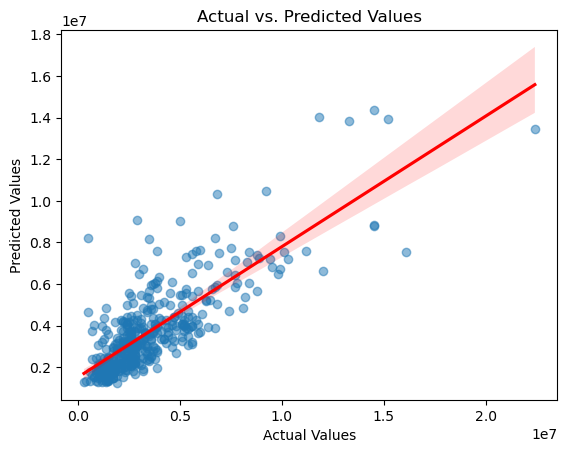

                             feature_importance
uninsured                              0.096920
total_patients                         0.089783
TotalWeeklyHoursOfOperation            0.068910
low_income                             0.057781
medicaid                               0.048030
total_grant_funding                    0.036857
hispanic_any_race                      0.036849
lep_patients                           0.030971
medicare_18_up                         0.030535
diverse_patients_sum                   0.029859
total_sites                            0.029648
ZipCode_Count                          0.025396
homeless_patients                      0.021687
uninsured_ratio                        0.017584
migrant_patients                       0.017424


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_15735/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [48]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rr, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rr, X_test_rr, y_train, y_test)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### D. RandomForestRegressor with PCA

R2 Score: 0.6355033212283014, Root Mean Squared Error: 1614167.4888070177, Mean Absolute Error: 1122562.918312655


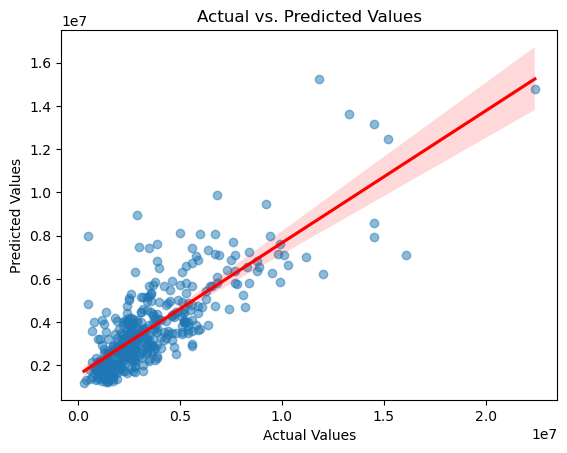

                             feature_importance
total_patients                         0.083675
uninsured                              0.078988
low_income                             0.063892
TotalWeeklyHoursOfOperation            0.062752
total_grant_funding                    0.039581
medicaid                               0.038440
hispanic_any_race                      0.038320
diverse_patients_sum                   0.034474
lep_patients                           0.031129
total_sites                            0.029382
ZipCode_Count                          0.027278
PC 2                                   0.023492
PC 3                                   0.021068
homeless_patients                      0.020852
medicare_18_up                         0.019881


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_15735/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [49]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_pca_rr, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_pca_rr, X_test_pca_rr, y_train, y_test)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_pca_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_robust', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### Rounded

R2 Score: 0.6349054971503844, Root Mean Squared Error: 1615319.092845794, Mean Absolute Error: 1120769.2307692308


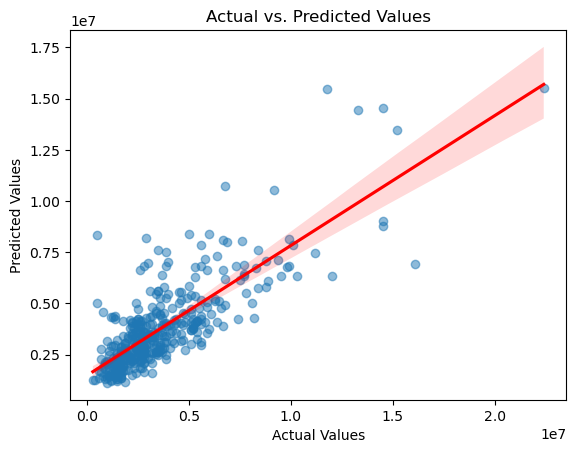

                             feature_importance
uninsured                              0.090715
total_patients                         0.084295
TotalWeeklyHoursOfOperation            0.069986
low_income                             0.069403
total_grant_funding                    0.055301
hispanic_any_race                      0.038124
lep_patients                           0.033111
medicaid                               0.032994
diverse_patients_sum                   0.029822
medicare_18_up                         0.027398
total_sites                            0.024851
homeless_patients                      0.021230
private_insurance                      0.020208
uninsured_ratio                        0.018864
ZipCode_Count                          0.018349


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_15735/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [50]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rr, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rr, X_test_rr, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

## II. Reduced & Power Transformed Data

##### Importing Data

### C. Random Forest Regressor with GridSearch

In [51]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train_rp, y_train)

y_pred = rf_gridsearch.predict(X_test_rp)
print(rf_gridsearch.score(X_test_rp, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.644035157926083
Best parameters: {'criterion': 'friedman_mse', 'max_depth': None, 'max_features': 10, 'n_estimators': 100, 'n_jobs': -1}


R2 Score: 0.6463194694349033, Root Mean Squared Error: 1590037.5653289945, Mean Absolute Error: 1108479.1818362281


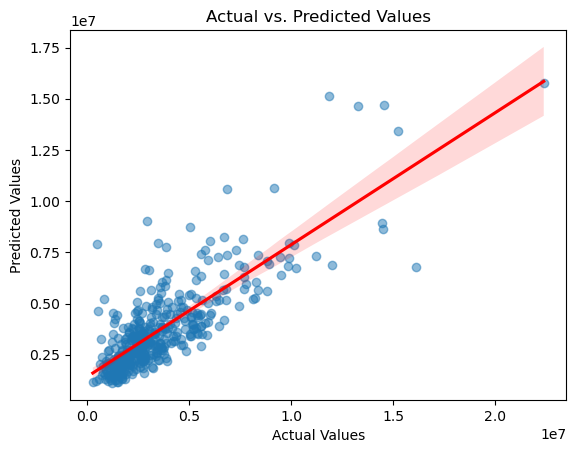

                             feature_importance
uninsured                              0.146351
total_patients                         0.114140
TotalWeeklyHoursOfOperation            0.077194
low_income                             0.064861
total_sites                            0.054934
medicaid                               0.050455
hispanic_any_race                      0.046214
diverse_patients_sum                   0.044426
total_grant_funding                    0.043389
lep_patients                           0.036852
medicare_18_up                         0.023256
ZipCode_Count                          0.020978
homeless_patients                      0.018219
migrant_patients                       0.016103
uninsured_ratio                        0.013949


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_15735/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [52]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rp, X_test_rp, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### D. RandomForestRegressor with PCA

R2 Score: 0.6636590003901189, Root Mean Squared Error: 1550571.2007834169, Mean Absolute Error: 1090690.4315632754


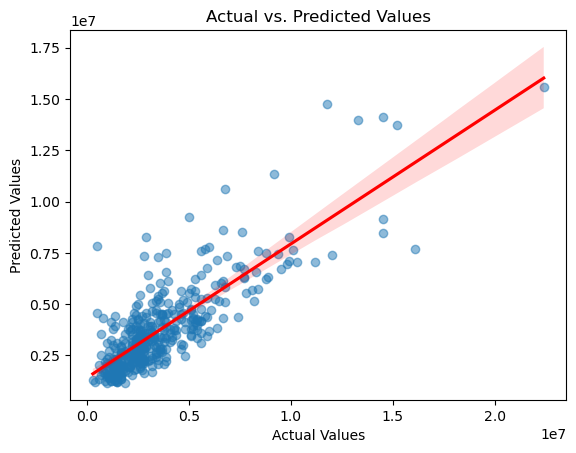

                             feature_importance
PC 1                                   0.125703
uninsured                              0.110429
total_patients                         0.087061
low_income                             0.081985
TotalWeeklyHoursOfOperation            0.058511
hispanic_any_race                      0.055895
medicaid                               0.038278
total_sites                            0.031649
diverse_patients_sum                   0.030862
total_grant_funding                    0.028407
medicare_18_up                         0.027546
SiteCity_Count                         0.018542
lep_patients                           0.016385
migrant_patients                       0.014077
private_insurance                      0.012825


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_15735/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [53]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_pca_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_pca_rp, X_test_pca_rp, y_train, y_test)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_pca_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_power', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### Rounded

R2 Score: 0.6435840018374367, Root Mean Squared Error: 1596005.0980347316, Mean Absolute Error: 1104114.1439205955


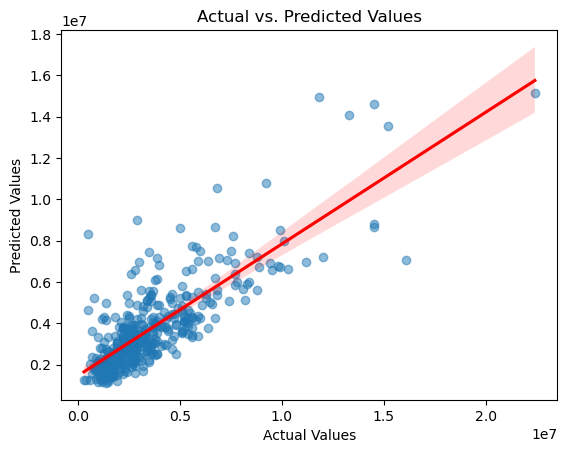

                             feature_importance
total_patients                         0.110331
uninsured                              0.109054
low_income                             0.090397
medicaid                               0.071761
TotalWeeklyHoursOfOperation            0.064426
hispanic_any_race                      0.058258
total_grant_funding                    0.056188
diverse_patients_sum                   0.038232
total_sites                            0.038222
lep_patients                           0.028931
medicare_18_up                         0.024454
ZipCode_Count                          0.023469
SiteCity_Count                         0.018016
homeless_patients                      0.017864
private_insurance                      0.016692


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_15735/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [54]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rp, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rp, X_test_rp, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_power_rounded', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

## III. Imputed & Robust Scaled Data

##### Importing Data

### B. Random Forest Regressor

In [55]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train_ir, y_train)

y_pred = rf_gridsearch.predict(X_test_ir)
print(rf_gridsearch.score(X_test_ir, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6564197689215313
Best parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 10, 'n_estimators': 50, 'n_jobs': -1}


R2 Score: 0.629998652929256, Root Mean Squared Error: 1626310.4804856565, Mean Absolute Error: 1114107.8819354838


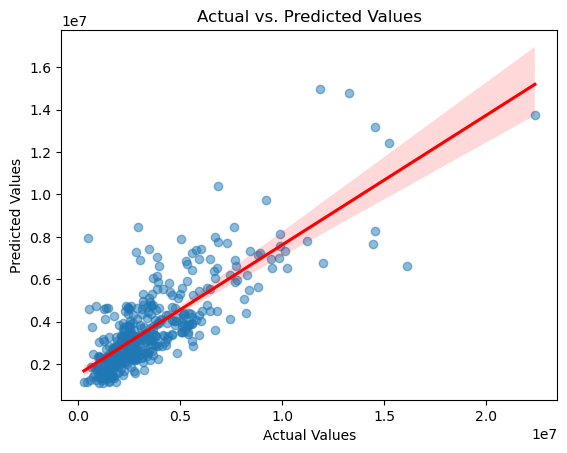

                             feature_importance
uninsured                              0.093464
total_patients                         0.070840
total_cost_care                        0.070558
total_visits                           0.060341
TotalWeeklyHoursOfOperation            0.053414
medicaid                               0.052504
low_income                             0.046742
hispanic_any_race                      0.037062
total_grant_funding                    0.035168
total_sfs                              0.026948
medicare_18_up                         0.025023
diverse_patients_sum                   0.021879
lep_patients                           0.018595
total_sites                            0.017516
ZipCode_Count                          0.017164


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_15735/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [56]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ir, X_test_ir, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ir.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### Rounded

R2 Score: 0.6485370516272573, Root Mean Squared Error: 1584876.6004675813, Mean Absolute Error: 1112488.8337468982


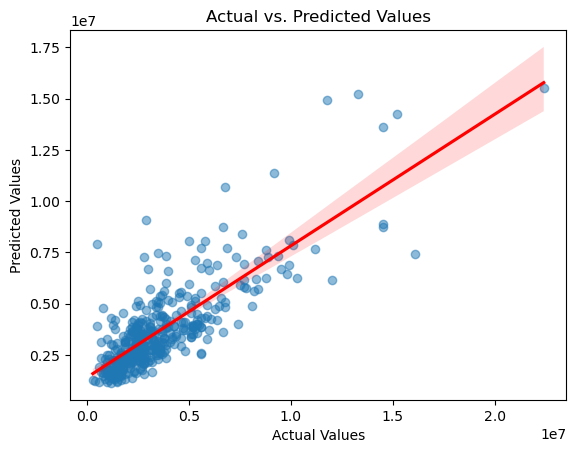

                             feature_importance
total_patients                         0.117176
uninsured                              0.087946
low_income                             0.064615
total_visits                           0.059547
total_cost_care                        0.046806
TotalWeeklyHoursOfOperation            0.041894
medicaid                               0.035339
hispanic_any_race                      0.032983
total_sfs                              0.029187
total_sites                            0.027011
diverse_patients_sum                   0.022663
total_grant_funding                    0.022470
medicare_18_up                         0.022359
private_insurance                      0.021684
uninsured_ratio                        0.019591


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_15735/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [57]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ir, X_test_ir, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ir.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

## IV. Imputed & Power Transformed Data

##### Importing Data

### B. Random Forest Regressor

In [58]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, scoring='r2', cv=kf)

rf_gridsearch.fit(X_train_ip, y_train)

y_pred = rf_gridsearch.predict(X_test_ip)
print(rf_gridsearch.score(X_test_ip, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.646003665161107
Best parameters: {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50, 'n_jobs': -1}


R2 Score: 0.5045026340871696, Root Mean Squared Error: 1882012.411509969, Mean Absolute Error: 1192690.025345446


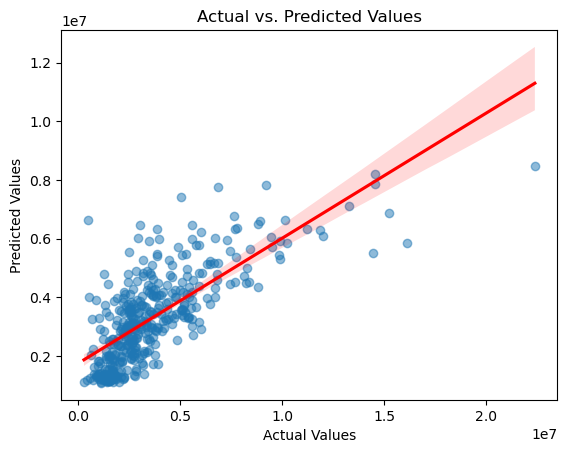

                             feature_importance
uninsured                              0.098507
total_patients                         0.077322
total_visits                           0.073965
low_income                             0.068253
total_cost_care                        0.067759
hispanic_any_race                      0.056715
total_sfs                              0.051999
TotalWeeklyHoursOfOperation            0.048935
total_sites                            0.035860
total_grant_funding                    0.028269
medicaid                               0.028123
lep_patients                           0.027517
medicare_18_up                         0.021476
diverse_patients_sum                   0.021299
migrant_patients                       0.019834


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_15735/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [59]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ip, X_test_ip, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ip.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### Rounded

R2 Score: 0.5118449765907513, Root Mean Squared Error: 1867818.0193959472, Mean Absolute Error: 1192060.703812503


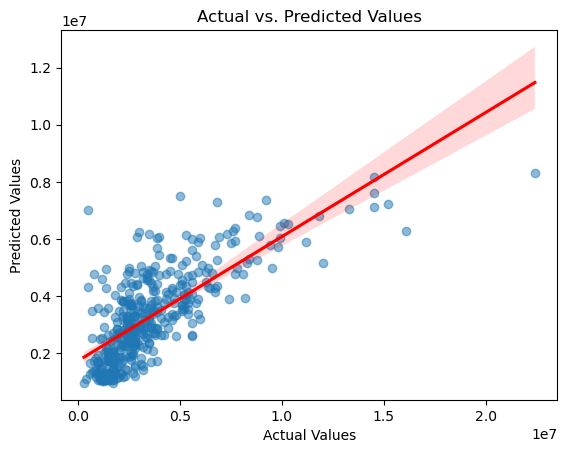

                             feature_importance
uninsured                              0.115486
total_cost_care                        0.101013
total_patients                         0.086371
total_sfs                              0.052873
total_visits                           0.051033
low_income                             0.045720
TotalWeeklyHoursOfOperation            0.044908
total_grant_funding                    0.043096
total_sites                            0.040660
medicaid                               0.039622
hispanic_any_race                      0.033705
medicare_18_up                         0.027147
diverse_patients_sum                   0.020639
lep_patients                           0.018737
migrant_patients                       0.015984


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_15735/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [60]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ip, X_test_ip, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ip.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_power_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

# Scoring Summary

In [61]:
model_scores.sort_values('score_r2_test', ascending=False)

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
16,Random Forest Regressor,reduced_power,True,5.907157e+05,1.550571e+06,3.942584e+05,1.090690e+06,0.954488,0.663659,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
19,Random Forest Regressor,imputed_robust_rounded,False,8.100437e+05,1.584877e+06,5.709127e+05,1.112489e+06,0.914428,0.648537,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
5,Linear Regression,reduced_power_rounded,False,1.614146e+06,1.585462e+06,1.132288e+06,1.181161e+06,0.660220,0.648277,0.597588,0.018902,-3.063558e+12,2.010730e+11,-1.226610e+06,68735.188352,None
3,Linear Regression,reduced_power,False,1.613415e+06,1.586355e+06,1.130684e+06,1.181633e+06,0.660483,0.647956,0.597809,0.018813,-3.061324e+12,2.023030e+11,-1.224908e+06,68628.524303,None
11,Linear Regression,imputed_power_rounded,False,1.604360e+06,1.586432e+06,1.129466e+06,1.180933e+06,0.664327,0.647847,0.595048,0.019240,-3.086108e+12,2.458439e+11,-1.237485e+06,62852.226495,None
9,Linear Regression,imputed_power,False,1.603669e+06,1.587244e+06,1.127989e+06,1.181993e+06,0.664572,0.647561,0.595336,0.018926,-3.083386e+12,2.462475e+11,-1.236020e+06,62415.884105,None
15,Random Forest Regressor,reduced_power,False,6.277669e+05,1.590038e+06,4.068224e+05,1.108479e+06,0.948600,0.646319,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
4,Linear Regression,reduced_power,True,1.617562e+06,1.591696e+06,1.130458e+06,1.181427e+06,0.658735,0.645581,0.597809,0.018813,-3.061324e+12,2.023030e+11,-1.224908e+06,68628.524303,None
17,Random Forest Regressor,reduced_power_rounded,True,6.250103e+05,1.596005e+06,4.060234e+05,1.104114e+06,0.949057,0.643584,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
10,Linear Regression,imputed_power,True,1.613273e+06,1.606340e+06,1.129415e+06,1.184694e+06,0.660543,0.639030,0.595336,0.018926,-3.083386e+12,2.462475e+11,-1.236020e+06,62415.884105,None


In [62]:
best_forest = model_scores[model_scores['model_type'] == 'Random Forest Regressor']\
                .sort_values('score_r2_test', ascending=False).head(2)
best_linreg = model_scores[model_scores['model_type'] == 'Linear Regression']\
                .sort_values('score_r2_test', ascending=False).head(2)

top_models = pd.concat([best_forest, best_linreg], ignore_index=True)
top_models

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
0,Random Forest Regressor,reduced_power,True,5.907157e+05,1.550571e+06,3.942584e+05,1.090690e+06,0.954488,0.663659,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
1,Random Forest Regressor,imputed_robust_rounded,False,8.100437e+05,1.584877e+06,5.709127e+05,1.112489e+06,0.914428,0.648537,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
2,Linear Regression,reduced_power_rounded,False,1.614146e+06,1.585462e+06,1.132288e+06,1.181161e+06,0.660220,0.648277,0.597588,0.018902,-3.063558e+12,2.010730e+11,-1.226610e+06,68735.188352,None
3,Linear Regression,reduced_power,False,1.613415e+06,1.586355e+06,1.130684e+06,1.181633e+06,0.660483,0.647956,0.597809,0.018813,-3.061324e+12,2.023030e+11,-1.224908e+06,68628.524303,None


In [63]:
# best_params for the first rf model
best_params_first_model = top_models.loc[0, 'best_params']
print(best_params_first_model)

# best_params for the second rf model
best_params_second_model = top_models.loc[1, 'best_params']
print(best_params_second_model)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'max_depth': None, 'max_features': 10, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 10, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 50, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


# Model Tuning

### **Reduced Power Model with PCA Features**

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 10, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}



In [64]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

forest_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [90, 100, 130], 
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 10, 20, 'log2'], 
    'min_samples_split': [2, 3, 5], 
    'min_samples_leaf': [1, 2, 4],  
    'criterion': ['absolute_error', 'friedman_mse', 'squared_error'], 
    'bootstrap': [True],  
    'n_jobs': [-1], 
}

forest_gs = GridSearchCV(forest_model, param_grid=param_grid, cv=kf)

forest_gs.fit(X_train_pca_rp, y_train)

y_pred = forest_gs.predict(X_test_pca_rp)
print(forest_gs.score(X_test_pca_rp, y_test))

best_params = forest_gs.best_params_
print("Best parameters:", best_params)

0.6533294448450018
Best parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': None, 'max_features': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 90, 'n_jobs': -1}


R2 Score: 0.6621142211476213, Root Mean Squared Error: 1752659.3727011054, Mean Absolute Error: 1139253.093420398


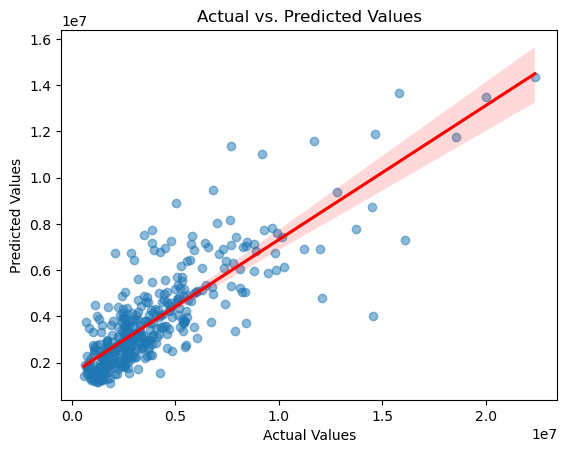

                             feature_importance
PC 1                                   0.152718
total_patients                         0.115656
uninsured                              0.102920
TotalWeeklyHoursOfOperation            0.067786
hispanic_any_race                      0.035166
low_income                             0.030817
total_grant_funding                    0.030002
medicaid                               0.027641
total_sites                            0.019645
PC 4                                   0.018066
SiteCity_Count                         0.015362
private_insurance                      0.014797
medicare_18_up                         0.014212
diverse_patients_sum                   0.014023
medicaid_ratio                         0.013977


In [75]:
rf_model_1 = RandomForestRegressor(**best_params, random_state=33)

rf_model_1.fit(X_train_pca_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model_1, X_train_pca_rp, X_test_pca_rp, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model_1.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_pca_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(20))

In [76]:
y_pred_train = rf_model_1.predict(X_train_pca_rp)

In [77]:
residuals = y_test - y_pred

# Create a DataFrame to analyze the residuals
results_df = pd.DataFrame({
    'Actual': y_test.flatten(), 
    'Predicted': y_pred.flatten(),
    'Residuals': residuals.flatten(),
    'Absolute_Residuals': abs(residuals).flatten()
})

# Sort the df by absolute residuals in descending order
results_df = results_df.sort_values(by='Absolute_Residuals', ascending=False)

results_df[['Absolute_Residuals']].describe().apply(lambda x: x.apply('{0:.2f}'.format))

,Absolute_Residuals
count,402.00
mean,1139253.09
std,1333544.52
min,7117.86
25%,333823.93
50%,734507.27
75%,1392731.36
max,10551145.46


In [78]:
residuals_train = y_train - y_pred_train

# Create a DataFrame to analyze the residuals
results_df_train = pd.DataFrame({
    'Actual': y_train.flatten(), 
    'Predicted': y_pred_train.flatten(),
    'Residuals': residuals_train.flatten(),
    'Absolute_Residuals': abs(residuals_train).flatten()
})

# Sort the df by absolute residuals in descending order
results_df_train = results_df_train.sort_values(by='Absolute_Residuals', ascending=False)

In [79]:
combined_data_test = pd.merge(X_test_rr, results_df, left_index=True, right_index=True, how='inner')

combined_data_train = pd.merge(X_train_rr, results_df_train, left_index=True, right_index=True, how='inner')
combined_data = pd.concat([combined_data_train, combined_data_test], axis=0)

In [80]:
df = pd.read_csv(DATA_PATH +'modeling/data_new_features.csv')
df.shape

(1340, 74)

In [85]:
combined_data = pd.merge(combined_data_test, df[['HealthCenterName', 'HealthCenterState']], left_index=True, right_index=True, how='inner')


In [89]:
combined_data.head(2)

,FundingCHC,FundingMHC,FundingHO,FundingPH,total_other_revenue,hispanic_any_race,total_patients,lep_patients,medicare_18_up,migrant_patients,...,other_revenue_category_1M to 30M,other_revenue_category_Less than 100K,other_revenue_category_Over 30M,other_revenue_category_Zero,Actual,Predicted,Residuals,Absolute_Residuals,HealthCenterName,HealthCenterState
0,0.0,0.0,0.0,0.0,0.172906,0.07084,0.126890,0.833120,-0.075277,-0.208909,...,0.0,0.0,0.0,0.0,2547838,3594789.440,-1046951.440,1046951.440,"HOLYOKE HEALTH CENTER, INC.",MA
1,0.0,0.0,0.0,0.0,-0.268738,-0.05062,1.380709,-0.242674,1.579095,-0.208909,...,0.0,0.0,0.0,1.0,2425436,4877260.235,-2451824.235,2451824.235,MAINE MOBILE HEALTH PROGRAM INC.,ME


In [87]:
combined_data[['Absolute_Residuals']].describe().apply(lambda x: x.apply('{0:.2f}'.format))

,Absolute_Residuals
count,402.00
mean,1139253.09
std,1333544.52
min,7117.86
25%,333823.93
50%,734507.27
75%,1392731.36
max,10551145.46


In [88]:
combined_data.groupby('HealthCenterState')[['Absolute_Residuals']].describe().apply(lambda x: x.apply('{0:.2f}'.format))

Absolute_Residuals                                     \
                               count        mean         std        min   
HealthCenterState                                                         
AL                              5.00  2250663.04  2716957.35   10075.89   
CT                             16.00  1539461.00  1898507.03  130087.86   
DC                              8.00   517440.48   489154.06  124330.56   
DE                              3.00   274140.76   169892.26   92619.97   
FL                             26.00   932765.35   970455.42   10875.51   
GA                             10.00   651582.17   845297.72   43750.90   
KY                              7.00   842996.79   677528.60   74159.62   
MA                             37.00  1168224.77  1211859.30   70974.88   
MD                             17.00  1209872.84   958062.79   11690.26   
ME                             18.00  1150947.00  1004606.87   43965.10   
MS                             10.00  1302751.91  1640458.98   83088.46   
NC                              9.00   753749.32   738351.29   65779.08   
NH                              9.00  1472626.58  1204763.36  206045.83   
NJ                             23.00  1062370.52  1412846.11  131653.47   
NY                             63.00  1106589.90  1154095.90   40771.24   
PA                             42.00   947988.06   876577.95    7117.86   
RI                              8.00  1094769.98   720885.40  116607.76   
SC                             10.00  1529254.33  2640338.46   92458.81   
TN                             16.00  1833722.77  2122666.16   92838.59   
VA                             26.00  1005963.25   981107.09  287067.81   
VT                             11.00  2354838.76  2886095.90   32309.12   
WV                             28.00   838449.39   853863.43   43839.68   

                                                                    
                          25%         50%         75%          max  
HealthCenterState                                                   
AL                  212621.68   744040.20  4321976.75   5964600.67  
CT                  374524.73   853547.32  1723875.82   7294754.96  
DC                  183681.74   362157.53   607272.32   1557065.17  
DE                  196546.31   300472.65   364901.15    429329.66  
FL                  240531.12   728597.31   997341.11   3872067.69  
GA                  210489.18   230849.15   775816.14   2781156.19  
KY                  215775.92  1007780.09  1283058.86   1821368.26  
MA                  402775.63   968107.48  1471702.83   6530249.54  
MD                  554680.05   954412.71  1470572.83   3327509.25  
ME                  334930.73   815668.40  1653485.16   3442689.57  
MS                  503311.75   838380.98  1186868.82   5786033.40  
NC                  418669.00   548762.32   703027.72   2613658.67  
NH                  549970.97  1321837.38  2178336.95   3912151.07  
NJ                  378343.80   658743.20  1040716.33   6801302.35  
NY                  327447.08   715484.91  1281290.31   4679019.08  
PA                  324338.81   726069.17  1381278.29   3627319.36  
RI                  624528.14   988987.61  1620203.98   2154639.65  
SC                  197836.02   640475.81  1447280.74   8814568.00  
TN                  754657.29  1050887.73  1923495.62   8028933.55  
VA                  460107.61   687473.49  1047535.56   4052491.18  
VT                 1014504.78  1660560.10  2534017.19  10551145.46  
WV                  325355.65   496094.83  1183009.02   3881449.66

# Results

The model called rf_model_1 performed the best in terms of R2 score. This model was trained and tested with the Reduced Power train/test split that also included PCA features in the dataset. 

Here were the results:

R2 Score: 0.6621142211476213, Root Mean Squared Error: 1752659.3727011054, Mean Absolute Error: 1139253.093420398

The linear regression models and random forest regressors performed better using the reduced dataset, which columns containing a lot of values were removed instead of imputed.